# DiploDatos 2019 - Análisis de Series Temporales

## Integrantes

| Nombre | e-mail |
|------|------|
|Rivadero, Isabel | isarivadero@hotmail.com |
|Vargas, Miguel | lvc0107@protonmail.com |
|Mancuso, Fernando | manquius@gmail.com |

## Práctico de Introducción al aprendizaje automático

En este práctico no introduciremos en las primeras herramientas de aprendizaje
automático. Diseñaremos e implementaremos algunos modelos simples y definir métricas
para ver como performan.

### Dataset

In [123]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set(rc={'figure.figsize':(10,6)})

cols = ['service',
        'sender_zipcode',
        'receiver_zipcode',
        'sender_state',
        'receiver_state',
        'shipment_type',
        'quantity',
        'status',
        'date_created',
        'date_sent',
        'date_visit',
        'target']
cols_holidays = ['holiday', 
                 'description']
data_path = './shipments_BR_201903.csv'
holidays = './holidays.csv'
from ml.visualization import plot_confusion_matrix
from sklearn.metrics import recall_score, precision_score


#### Referencia de las columnas
* **service**: Identificador unico que corresponde a un tipo de servicio de un correo en particular.
* **sender_zipcode:** Código postal de quien envía el paquete (usualmente el vendedor).
* **receiver_zipcode:** Código postal de quien recibe el paquete (usualmente el comprador).
* **sender_state:** Nombre abreviado del estado de quien envía el paquete.
* **receiver_state:** Nombre abreviado del estado de quien recibe el paquete.
* **quantity:** Cantidad de items que tiene dentro el paquete.
* **status:** Estado final del envío.
* **date_created:** Fecha de compra de el o los items.
* **date_sent:** Fecha en que el correo recibe el paquete.
* **date_visit:** Fecha en que el correo entrega el paquete.
* **target:** Cantidad de dias hábiles que tardó el correo en entregar el paquete desde que lo recibe.


In [2]:
df = pd.read_csv(data_path, usecols=cols)
df.shape

(1000000, 12)

In [3]:
# set seed for reproducibility
np.random.seed(0)

**Eliminamos datos inconsistentes:**

Aplicamos curacion y limpieza de datos

In [102]:
cleaned_df = df[(df['date_sent'] <= df['date_visit']) & (df['date_created'] <= df['date_sent']) & (df['date_created'] <= df['date_visit'])].copy()
cleaned_df.shape

(999827, 12)

**Removemos outliers.**

In [103]:
cleaned_df = cleaned_df[cleaned_df['target'] < 23].copy()
cleaned_df.shape

(990370, 12)

####  Implementación
Solo vamos a diferenciar dos tipos de envíos:
​ rápidos: un envío es rápido si llega antes de 3 días hábiles 
​ y lentos: si llega después de 3 días hábiles.
Esto nos reduce los problemas de clasificación a solo 2 clases.


#### Definiciones básicas:
1- Definir una métrica binaria para evaluar los modelos



In [6]:
def metrica(target):
    """
    1: Servicio rapido
    0: Servicio lento
    """
    return int(target < 3)

2- Diseñar un modelo -baseline- para los envíos de SP a SP, como el modelo más
simple posible. Para esto no necesitamos machine learning, solo proponer una
heurística a partir de los datos observados en los prácticos de análisis


In [7]:
sp_sp = cleaned_df[(cleaned_df['sender_state'] == 'SP') & (cleaned_df['receiver_state'] == 'SP')]

In [8]:
sp_sp.shape

(278081, 12)

3- Calcular la métrica y la matriz de confusión para el baseline

#### Preparación de los features:
4- Con la intención de salvar las rutas poco representadas, implementar una codificación para los features:  sender_zipcode y  receiver_zipcode



In [11]:
cleaned_df['sender_state'].value_counts()

SP    722085
PR     69115
MG     60645
RJ     40803
SC     31208
RS     22591
GO      8323
ES      8020
BA      5569
DF      4809
PE      4329
CE      3206
MS      2710
PB      1623
RN       825
MT       683
PA       565
AM       557
PI       525
RO       519
SE       489
AL       447
MA       318
TO       203
AC        75
RR        67
AP        61
Name: sender_state, dtype: int64

In [12]:
state_codes = {
  "SP": 1,
  "PR": 2,
  "MG": 3,
  "RJ": 4,
  "SC": 5,
  "RS": 6,
  "GO": 7,
  "ES": 8,
  "BA": 9,
  "DF": 10,
  "PE": 11,
  "CE": 12,
  "MS": 13,
  "PB": 14,
  "RN": 15,
  "MT": 16,
  "PA": 17,
  "AM": 18,
  "PI": 19,
  "RO": 20,
  "SE": 21,
  "AL": 22,
  "MA": 23,
  "TO": 24,
  "AC": 25,
  "RR": 26,
  "AP": 27
}

In [13]:
grouped_zipcodes_df = cleaned_df.copy()

def convert_zipcodes(zipcode):
    return state_codes[zipcode]

grouped_zipcodes_df['sender_zipcode'] = grouped_zipcodes_df.sender_state.map(convert_zipcodes)
grouped_zipcodes_df['receiver_zipcode'] = grouped_zipcodes_df.receiver_state.map(convert_zipcodes)
grouped_zipcodes_df.head()

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,target
0,SP,1,SP,1,express,1,0,done,2019-03-04 00:00:00,2019-03-05 13:24:00,2019-03-07 18:01:00,2
1,SP,1,MG,3,standard,1,1,done,2019-03-19 00:00:00,2019-03-20 14:44:00,2019-03-27 10:21:00,5
2,SP,1,SP,1,express,1,0,done,2019-02-18 00:00:00,2019-02-21 15:08:00,2019-02-28 18:19:00,5
3,SP,1,SP,1,express,1,0,done,2019-03-09 00:00:00,2019-03-11 15:48:00,2019-03-12 13:33:00,1
4,SP,1,RS,6,express,1,0,done,2019-03-08 00:00:00,2019-03-12 08:19:00,2019-03-16 08:24:00,4


**5- Seleccionar un conjunto de features para entrenar modelos de machine learning**

In [14]:
grouped_zipcodes_df['target'] = grouped_zipcodes_df.target.map(metrica)

In [ ]:
## Construyo matriz de features
features = grouped_zipcodes_df[['service', 'sender_zipcode', 'receiver_zipcode']].copy()
features.head()


In [ ]:
#Normalizacion
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


In [ ]:
## Estandarizo varables
#X = scaled_df.values
X = scaler.fit_transform(features).copy()


## Construyo vector de targets (con valor numérico)
y = grouped_zipcodes_df['target'].values

#### Clustering:
6- Clusterizar los envíos basados únicamente en las rutas. Para esto recomiendo utilizar KMeans


In [ ]:
# but it couldn be useful for you depending on your approach)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def precision(yPred, yTest):
    N = len(yTest)
    prec = (yPred == yTest).sum() / N
    return prec if prec > 0.5 else 1-prec

In [ ]:
from sklearn.cluster import KMeans


K = range(1,10)
for k in K:
    ## Inicializo clasificador
    classifier = KMeans(n_clusters=k, max_iter=1000, random_state=2)
    print(classifier)

    ## Entreno
    kmeans = classifier.fit(X_train)

    ## Centros de los clusters
    centers = kmeans.cluster_centers_

    ## Realizo predicción sobre conjunto de prueba
    y_pred = kmeans.predict(X_test)

    ## Evaluo la precision del clasificador
    print('Porcentaje bien clasificado: {:.2f}%\n'.format(100*precision(y_pred, y_test)))
    print('='*100)

In [ ]:
plt.figure(figsize=(20, 10))


target = grouped_zipcodes_df.target == 1

ncols = 3
nrows = 1
fig, axes = plt.subplots(figsize=(7*ncols, 5*nrows), ncols=3, nrows=1)

ax = axes[0]
ax.scatter(grouped_zipcodes_df[target].sender_zipcode, grouped_zipcodes_df[target].receiver_zipcode, marker='*')
ax.scatter(grouped_zipcodes_df[~target].sender_zipcode, grouped_zipcodes_df[~target].receiver_zipcode, marker='+')
ax.scatter(centers[0][0], centers[0][1], color='k', s=100)
ax.scatter(centers[1][0], centers[1][1], color='k', s=100)
ax.set_xlabel('sender_zipcode')
ax.set_ylabel('receiver_zipcode')

ax = axes[1]
ax.scatter(grouped_zipcodes_df[target].sender_zipcode, grouped_zipcodes_df[target].service, s=100, marker='*')
ax.scatter(grouped_zipcodes_df[~target].sender_zipcode, grouped_zipcodes_df[~target].service, s=100, marker='+')
ax.scatter(centers[0][0], centers[0][2], color='k', s=100)
ax.scatter(centers[1][0], centers[1][2], color='k', s=100)
ax.set_xlabel('sender_zipcode')
ax.set_ylabel('service')

ax = axes[2]
ax.scatter(grouped_zipcodes_df[target].service, grouped_zipcodes_df[target].receiver_zipcode, marker='*')
ax.scatter(grouped_zipcodes_df[~target].service, grouped_zipcodes_df[~target].receiver_zipcode, marker='+')
ax.scatter(centers[0][1], centers[0][2], color='k', s=100)
ax.scatter(centers[1][1], centers[1][2], color='k', s=100)
ax.set_xlabel('service')
ax.set_ylabel('receiver_zipcode')


plt.tight_layout()
plt.show()

7- (*) Cual es el número óptimo de clusters? (Ver método de ​ Elbow​ con KMeans)


In [ ]:
KMeans(n_clusters=k).fit(X).cluster_centers_

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt


# create new plot and data
plt.plot()
X = df[['sender_zipcode', 'receiver_zipcode', 'service']]
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


8- Describir brevemente las características interesante de los clusters


#### Modelos lineales:
**9- Leer sobre accuracy, precision y recall para agregarlas al pool de métricas que vamos a utilizar.**


**10- Implementar un modelo basado en regresión lineal, calcular las métricas y la matriz de confusión**


Para estas pruebas usamos cleaned_df en lugar de grouped_zipcodes_df.Como primer enfoque vamos a tratar 
de encontra alguna relacion lineal entre un solo feature y el target

[[96835 38171]
 [55525  7543]]
accuracy_score: 0.526964669769884
recall_score: 0.11960106551658527


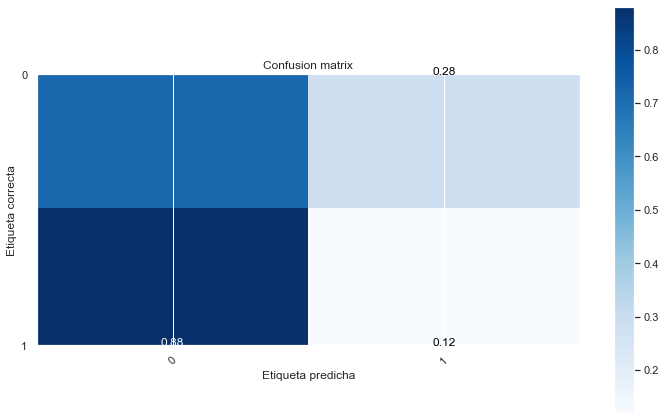

In [191]:
# but it couldn be useful for you depending on your approach)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

#First aproach: choose only one feature 
X = cleaned_df[['sender_zipcode']].copy()
y = cleaned_df.target.map(metrica)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
linear_reg = LinearRegression().fit(X_train, y_train)
y_pred = linear_reg.predict(X_test)
y_pred = (y_pred < 0.3) 
print(confusion_matrix(y_test, y_pred))
print(f"accuracy_score: {accuracy_score(y_test, y_pred)}")
print(f"recall_score: {recall_score(y_test, y_pred)}")
plot_confusion_matrix(confusion_matrix(y_test, y_pred), [0,1], normalize = True)

[[70027 64979]
 [51848 11220]]
accuracy_score: 0.41018508234296275
recall_score: 0.1779032155768377


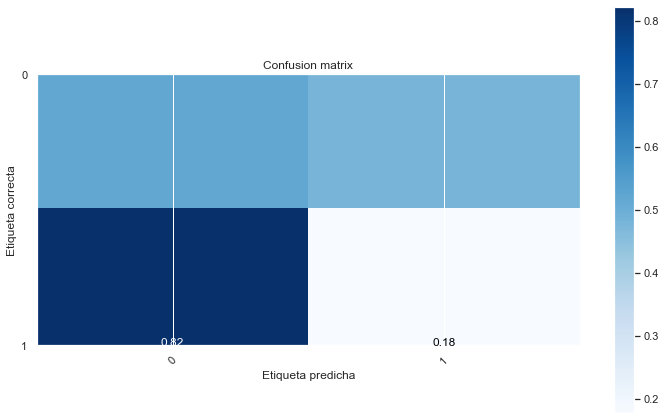

In [192]:
# but it couldn be useful for you depending on your approach)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

#First aproach: choose only one feature 
X = cleaned_df[['receiver_zipcode']].copy()
y = cleaned_df.target.map(metrica)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
linear_reg = LinearRegression().fit(X_train, y_train)
y_pred = linear_reg.predict(X_test)
y_pred = (y_pred < 0.3)
print(confusion_matrix(y_test, y_pred))
print(f"accuracy_score: {accuracy_score(y_test, y_pred)}")
print(f"recall_score: {recall_score(y_test, y_pred)}")
plot_confusion_matrix(confusion_matrix(y_test, y_pred), [0,1], normalize = True)

[[135006      0]
 [ 63068      0]]
accuracy_score: 0.6815937477912295
recall_score: 0.0


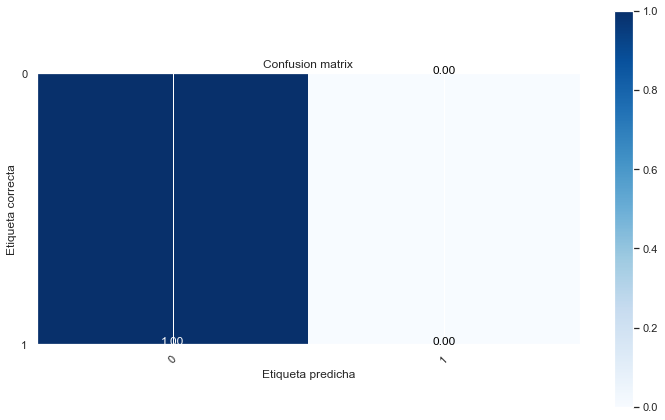

In [193]:
# but it couldn be useful for you depending on your approach)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

#First aproach: choose only one feature 
X = cleaned_df[['service']].copy()
y = cleaned_df.target.map(metrica)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
linear_reg = LinearRegression().fit(X_train, y_train)
y_pred = linear_reg.predict(X_test)
y_pred = (y_pred < 0.3)
print(confusion_matrix(y_test, y_pred))
print(f"accuracy_score: {accuracy_score(y_test, y_pred)}")
print(f"recall_score: {recall_score(y_test, y_pred)}")
plot_confusion_matrix(confusion_matrix(y_test, y_pred), [0,1], normalize = True)

[[64280 70726]
 [51028 12040]]
accuracy_score: 0.38531054050506375
recall_score: 0.19090505486141943


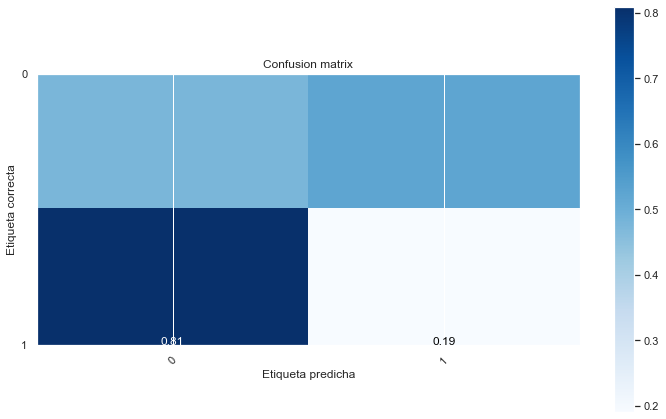

In [194]:
# but it couldn be useful for you depending on your approach)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

#Second aproach: choose two features 
X = cleaned_df[['sender_zipcode', 'receiver_zipcode']].copy()
y = cleaned_df.target.map(metrica)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
linear_reg = LinearRegression().fit(X_train, y_train)
y_pred = linear_reg.predict(X_test)
y_pred = (y_pred < 0.3)
print(confusion_matrix(y_test, y_pred))
print(f"accuracy_score: {accuracy_score(y_test, y_pred)}")
print(f"recall_score: {recall_score(y_test, y_pred)}")
plot_confusion_matrix(confusion_matrix(y_test, y_pred), [0,1], normalize = True)

[[96138 38868]
 [55297  7771]]
accuracy_score: 0.5245968678372729
recall_score: 0.12321621107376166


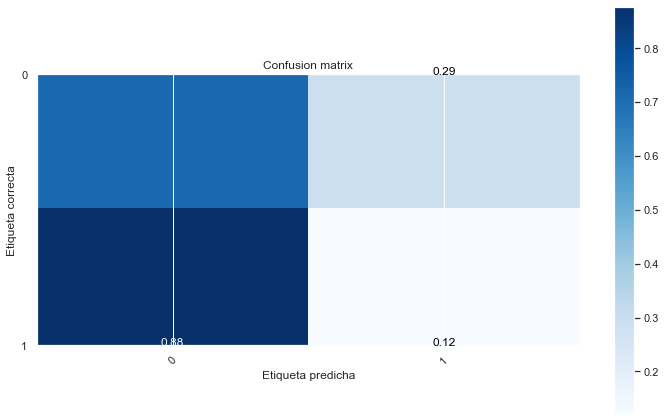

In [195]:
# but it couldn be useful for you depending on your approach)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

#Second aproach: choose two features 
X = cleaned_df[['sender_zipcode', 'service']].copy()
y = cleaned_df.target.map(metrica)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
linear_reg = LinearRegression().fit(X_train, y_train)
y_pred = linear_reg.predict(X_test)
y_pred = (y_pred < 0.3)
print(confusion_matrix(y_test, y_pred))
print(f"accuracy_score: {accuracy_score(y_test, y_pred)}")
print(f"recall_score: {recall_score(y_test, y_pred)}")
plot_confusion_matrix(confusion_matrix(y_test, y_pred), [0,1], normalize = True)

[[69748 65258]
 [51794 11274]]
accuracy_score: 0.4090491432494926
recall_score: 0.1787594342614321


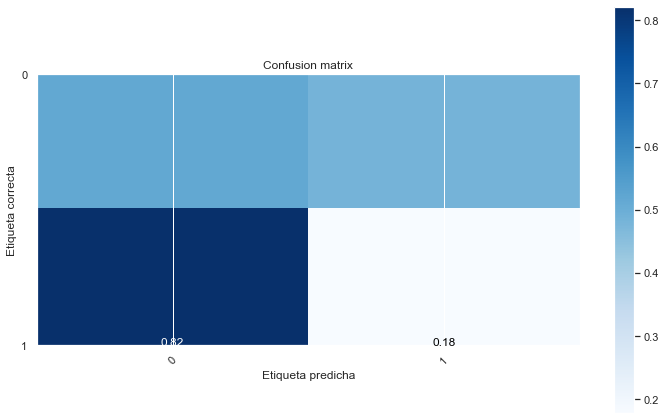

In [196]:
# but it couldn be useful for you depending on your approach)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

#Second aproach: choose two features 
X = cleaned_df[['receiver_zipcode', 'service']].copy()
y = cleaned_df.target.map(metrica)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
linear_reg = LinearRegression().fit(X_train, y_train)
y_pred = linear_reg.predict(X_test)
y_pred = (y_pred < 0.3)
print(confusion_matrix(y_test, y_pred))
print(f"accuracy_score: {accuracy_score(y_test, y_pred)}")
print(f"recall_score: {recall_score(y_test, y_pred)}")
plot_confusion_matrix(confusion_matrix(y_test, y_pred), [0,1], normalize = True)

[[64603 70403]
 [50691 12377]]
accuracy_score: 0.3886426285125761
recall_score: 0.19624849368935118


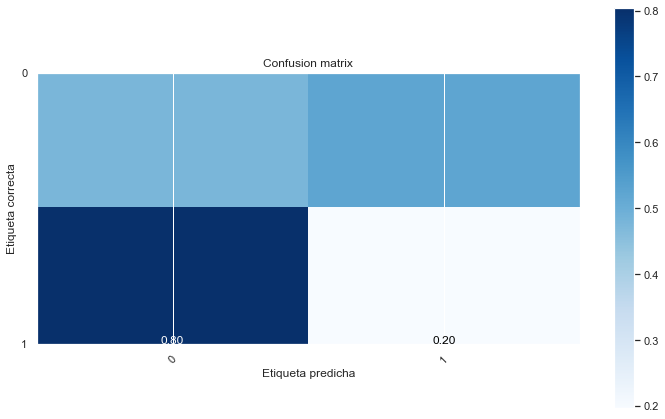

In [197]:
# but it couldn be useful for you depending on your approach)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

#Third aproach: choose three features 
X = cleaned_df[['sender_zipcode', 'receiver_zipcode', 'service']].copy()
y = cleaned_df.target.map(metrica)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
linear_reg = LinearRegression().fit(X_train, y_train)
y_pred = linear_reg.predict(X_test)
y_pred = (y_pred < 0.3)
print(confusion_matrix(y_test, y_pred))
print(f"accuracy_score: {accuracy_score(y_test, y_pred)}")
print(f"recall_score: {recall_score(y_test, y_pred)}")
plot_confusion_matrix(confusion_matrix(y_test, y_pred), [0,1], normalize = True)


**11- Implementar un modelo basado en regresión logística, calcular las métricas y la matriz de confusión**


/Users/luisvargas/code/migue/github/diplo/2019/diplo_venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[     0 135006]
 [     0  63068]]
accuracy_score: 0.31840625220877045
recall_score: 1.0


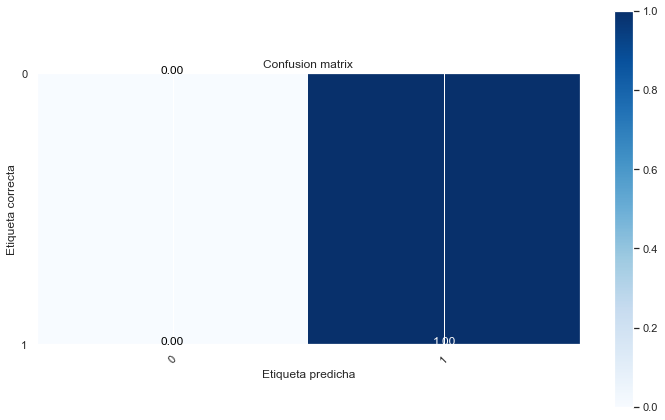

In [202]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

#Third aproach: choose three features 
X = cleaned_df[['sender_zipcode', 'receiver_zipcode']].copy()
y = cleaned_df.target.map(metrica)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
linear_reg = LogisticRegression().fit(X_train, y_train)
y_pred = linear_reg.predict(X_test)
y_pred = (y_pred < 0.3)
print(confusion_matrix(y_test, y_pred))
print(f"accuracy_score: {accuracy_score(y_test, y_pred)}")
print(f"recall_score: {recall_score(y_test, y_pred)}")
plot_confusion_matrix(confusion_matrix(y_test, y_pred), [0,1], normalize = True)


/Users/luisvargas/code/migue/github/diplo/2019/diplo_venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[     0 135006]
 [     0  63068]]
accuracy_score: 0.31840625220877045
recall_score: 1.0


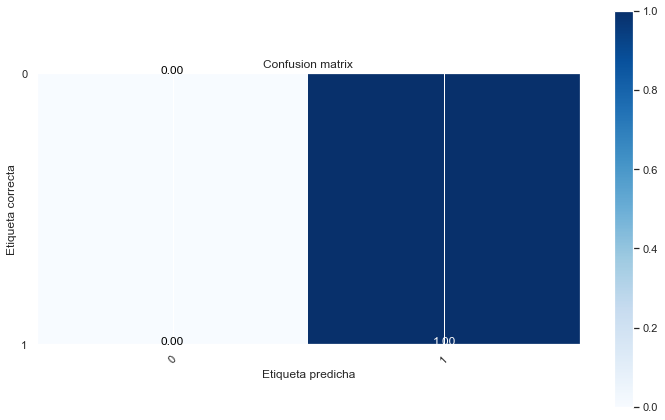

In [201]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

#Third aproach: choose three features 
X = cleaned_df[['sender_zipcode', 'receiver_zipcode', 'service']].copy()
y = cleaned_df.target.map(metrica)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
linear_reg = LogisticRegression().fit(X_train, y_train)
y_pred = linear_reg.predict(X_test)
y_pred = (y_pred < 0.3)
print(confusion_matrix(y_test, y_pred))
print(f"accuracy_score: {accuracy_score(y_test, y_pred)}")
print(f"recall_score: {recall_score(y_test, y_pred)}")
plot_confusion_matrix(confusion_matrix(y_test, y_pred), [0,1], normalize = True)


12- Cual es la principal diferencia entre estos modelos? Tuviste que hacer algún tipo de post-procesamiento?


13- Estandarizar los features seleccionados y re entrenar los modelos. Las métricas
mejoran? Explicar por qué.
